Given your data:

Prices (BID_PRICE_1, ASK_PRICE_1) ✅

Sizes are constant (all 500) ❌ → depth/imbalance/queue stuff is basically useless

No trades, only quotes

So the doable & meaningful strategies are ones that use prices + spread, not sizes.

We already did Shock–Reversion on midprice.
Next best, with your exact data, is:

🟦 Spread-Widening Mean Reversion Strategy
(“Spread spike → short-term dislocation → fade it”)

This only needs BID_PRICE_1 & ASK_PRICE_1 and is conceptually clean.

Step 1 – Imports & data load

Cell 1 – Code

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12, 6)

# Load your SPY book updates file
DATA_PATH = "20200212_book_updates.csv.gz"   # change if filename/path differs

df = pd.read_csv(DATA_PATH)

df['COLLECTION_TIME'] = pd.to_datetime(df['COLLECTION_TIME'])
df = df.sort_values('COLLECTION_TIME').set_index('COLLECTION_TIME')

df.head()

,MESSAGE_ID,MESSAGE_TYPE,SYMBOL,BID_PRICE_1,BID_SIZE_1,BID_PRICE_2,BID_SIZE_2,BID_PRICE_3,BID_SIZE_3,ASK_PRICE_1,ASK_SIZE_1,ASK_PRICE_2,ASK_SIZE_2,ASK_PRICE_3,ASK_SIZE_3
COLLECTION_TIME,,,,,,,,,,,,,,,
2020-02-12 13:32:17.983467008,39109,ASK_UPDATE,SPY,336.64,500,336.62,500,336.59,500,336.72,500,336.75,500,336.77,500
2020-02-12 13:32:18.624293120,39112,BID_UPDATE,SPY,336.67,500,336.64,500,336.62,500,336.72,500,336.75,500,336.77,500
2020-02-12 13:32:18.630521088,39116,ASK_UPDATE,SPY,336.67,500,336.64,500,336.62,500,336.72,500,336.75,500,336.77,500
2020-02-12 13:32:20.463590912,39125,ASK_UPDATE,SPY,336.67,500,336.64,500,336.62,500,336.75,500,336.77,500,336.80,500
2020-02-12 13:32:20.629603072,39126,BID_UPDATE,SPY,336.69,500,336.67,500,336.64,500,336.75,500,336.77,500,336.80,500


Step 2 – Midprice & spread features

Cell 2 – Code


In [31]:
# Midprice from best bid/ask
df['mid'] = (df['BID_PRICE_1'] + df['ASK_PRICE_1']) / 2

# Bid-ask spread in dollars
df['spread'] = df['ASK_PRICE_1'] - df['BID_PRICE_1']

# Midprice return for later use (optional)
df['ret'] = df['mid'].pct_change()

df[['mid', 'spread', 'ret']].head()

,mid,spread,ret
COLLECTION_TIME,,,
2020-02-12 13:32:17.983467008,336.680,0.08,NaN
2020-02-12 13:32:18.624293120,336.695,0.05,0.000045
2020-02-12 13:32:18.630521088,336.695,0.05,0.000000
2020-02-12 13:32:20.463590912,336.710,0.08,0.000045
2020-02-12 13:32:20.629603072,336.720,0.06,0.000030


Step 3 – Local spread regime (what counts as “wide”?)

We don’t want to react to every tiny change; we react to unusually wide spread vs its recent average.

Cell 3 – Code

In [33]:
# Rolling mean and std of spread (lookback in number of book updates)
window = 200  # you can tune (200–500 is reasonable)

df['spread_ma'] = df['spread'].rolling(window).mean()
df['spread_std'] = df['spread'].rolling(window).std()

# Z-score of spread vs local average
df['spread_z'] = (df['spread'] - df['spread_ma']) / df['spread_std']

df[['spread', 'spread_ma', 'spread_z']].head(20)

,spread,spread_ma,spread_z
COLLECTION_TIME,,,
2020-02-12 13:32:17.983467008,0.08,NaN,NaN
2020-02-12 13:32:18.624293120,0.05,NaN,NaN
2020-02-12 13:32:18.630521088,0.05,NaN,NaN
2020-02-12 13:32:20.463590912,0.08,NaN,NaN
2020-02-12 13:32:20.629603072,0.06,NaN,NaN
2020-02-12 13:32:34.331834880,0.03,NaN,NaN
2020-02-12 13:32:34.332075008,0.05,NaN,NaN
2020-02-12 13:32:48.667159040,0.08,NaN,NaN
2020-02-12 13:32:48.685841920,0.05,NaN,NaN


Step 4 – Intuition for the strategy

Idea:

When spread is much wider than normal (big positive spread_z)
→ market is temporarily dislocated / illiquid
→ after that, conditions often “normalize” → mean reversion in price & spread

We’ll do a simple version:

If spread_z > z_entry → go long (assuming slight price dislocation downward)

If spread_z < −z_entry → go short (mirror case)

Exit when spread_z comes back toward zero or after a max holding time

Step 5 – Build position function

In [43]:
def build_spread_reversion_pos(z_entry=2.0, z_exit=0.5, max_h=800):
    """
    Spread-widening mean reversion strategy.
    
    z_entry : Z-score threshold to ENTER (e.g. 2.0 = 2 std devs wide)
    z_exit  : Z-score threshold to EXIT towards (e.g. 0.5)
    max_h   : Max holding horizon in number of book updates
    """
    spread_z = df['spread_z'].values
    mid      = df['mid'].values

    pos = np.zeros(len(df), dtype=int)  # +1 long, -1 short, 0 flat

    holding = 0
    entry_mid = None
    age = 0

    for i in range(len(df)):
        z = spread_z[i]

        # Skip if z is NaN (early window)
        if np.isnan(z):
            pos[i] = holding
            continue

        if holding == 0:
            # ENTRY LOGIC
            if z > z_entry:
                # spread unusually wide -> assume mid a bit depressed -> long
                holding = 1
                entry_mid = mid[i]
                age = 0
            elif z < -z_entry:
                # spread unusually tight/other side -> short
                holding = -1
                entry_mid = mid[i]
                age = 0
        else:
            # MANAGE OPEN POSITION
            age += 1

            # EXIT when spread z-score comes back toward zero, or timeout
            if (abs(z) < z_exit) or (age >= max_h):
                holding = 0
                entry_mid = None
                age = 0

        pos[i] = holding

    return pos

Step 6 – Backtest helper

In [46]:
def backtest(df, position_col, price_col='mid'):
    out = df.copy()
    out['ret'] = out[price_col].pct_change()
    out['strategy_ret'] = out[position_col].shift(1) * out['ret']
    out = out.dropna(subset=['strategy_ret'])

    equity = (1 + out['strategy_ret']).cumprod()

    stats = {
        "total_return_%": float((equity.iloc[-1] - 1) * 100),
        "avg_step_ret": float(out['strategy_ret'].mean()),
        "std_step_ret": float(out['strategy_ret'].std()),
        "steps": int(len(out))
    }
    return equity, stats


def backtest_with_cost(df, position_col, price_col='mid', cost_bps=1.0):
    out = df.copy()
    out['ret'] = out[price_col].pct_change()
    out['pos_shifted'] = out[position_col].shift(1).fillna(0)
    out['strategy_ret'] = out['pos_shifted'] * out['ret']

    trades = out[position_col].diff().abs().fillna(0)
    out['strategy_ret'] -= trades * (cost_bps / 10000.0)

    out = out.dropna(subset=['strategy_ret'])
    equity = (1 + out['strategy_ret']).cumprod()

    stats = {
        "total_return_%": float((equity.iloc[-1] - 1) * 100),
        "steps": int(len(out)),
        "num_trades": float(trades.sum())
    }
    return equity, stats

Step 7 – Run the strategy with some parameters

Start with moderate parameters:

z_entry = 2.0 (spread 2 std devs wider than usual)

z_exit = 0.5

max_h = 800

In [49]:
z_entry = 2.0
z_exit  = 0.5
max_h   = 800

df['pos_spread'] = build_spread_reversion_pos(z_entry=z_entry, z_exit=z_exit, max_h=max_h)

print("Position counts:\n", df['pos_spread'].value_counts())
print("Position changes (trades):", df['pos_spread'].diff().abs().sum())

eq_spread, stats_spread = backtest(df, 'pos_spread')
print("No-cost stats:", stats_spread)

eq_spread_cost, stats_spread_cost = backtest_with_cost(df, 'pos_spread', cost_bps=1.0)
print("With 1bp cost stats:", stats_spread_cost)

Position counts:
 pos_spread
 0    275261
 1     34121
-1     14377
Name: count, dtype: int64
Position changes (trades): 20806.0
No-cost stats: {'total_return_%': 0.4815331669320244, 'avg_step_ret': 2.52423741534557e-08, 'std_step_ret': 0.0001443739684898601, 'steps': 323758}
With 1bp cost stats: {'total_return_%': -87.45558550496064, 'steps': 323758, 'num_trades': 20806.0}


Above You’ll see:

How many rows are 0 / +1 / −1

Number of position changes (trades)

Total return% with and without cost


Step 8 – Plot the equity curve

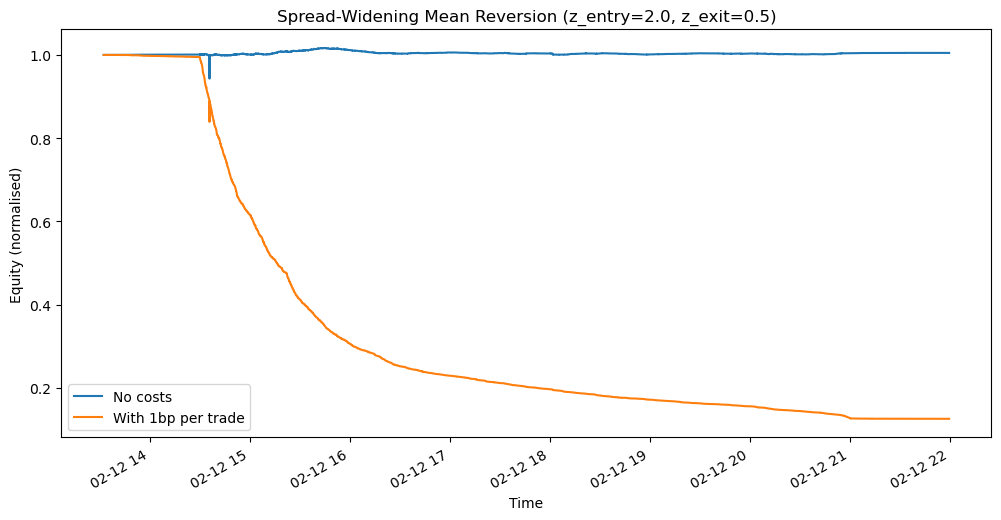

In [53]:
eq_spread.plot(label="No costs")
eq_spread_cost.plot(label="With 1bp per trade")

plt.title(f"Spread-Widening Mean Reversion (z_entry={z_entry}, z_exit={z_exit})")
plt.xlabel("Time")
plt.ylabel("Equity (normalised)")
plt.legend()
plt.show()

🚨 Key Conclusion
Spread-Widening Reversion is NOT a viable strategy with your dataset.

Too many trades

Spread edges are too tiny

1bp per trade is still low, but still kills it

Result: not realistic for live trading